# IRIS Traffic Map

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorly as tl
import time
from tqdm import tqdm
import os
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colrs

from descartes.patch import PolygonPatch

import common
import folium
from shapely.geometry import Point, mapping, box
from shapely.geometry import shape as Shape
from shapely.ops import transform as Shapely_transform

import mapply

from pyspark.sql import SparkSession
import pyspark.sql.functions as spark_functions
import pyspark.sql.types as spark_types
from pyspark.sql.functions import col, pandas_udf, PandasUDFType,udf,broadcast

In [2]:
# Font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['CMU Serif Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 18

wgs_to_ntf = common.transform_wgs_to_ntf()
ntf_to_wgs = common.transform_ntf_to_wgs()

mapply.init(
    n_workers=37,
    chunk_size=1,
    progressbar=True
)

In [3]:
USER = os.getlogin()
WORKING_DIR = f'/home/{USER}/data/Land_use'
DATA_DIR = f'{WORKING_DIR}/data'

CITY_NAME = 'Lyon'

In [4]:
spark = SparkSession.builder\
    .master('spark://santiago:7077')\
    .appName('1.5-IRIS_Traffic_Median_week')\
    .config('spark.network.timeout', 300)\
    .config('spark.dynamicAllocation.enabled', 'true')\
    .config('spark.shuffle.service.enabled', 'true')\
    .config('spark.dynamicAllocation.initialExecutors', 1)\
    .config('spark.dynamicAllocation.maxExecutors', 60)\
    .config('spark.dynamicAllocation.minExecutors', 1)\
    .config('spark.driver.maxResultSize', '120g')\
    .config('spark.executor.cores', 1)\
    .config('spark.executor.memory', '3g')\
    .config('spark.memory.fraction', 0.6)\
    .config('spark.cores.max', 60)\
    .config('spark.executor.memoryOverhead', '8g')\
    .config('spark.driver.memoryOverhead', '8g')\
    .getOrCreate()

spark.conf.set('spark.sql.session.timeZone', 'Europe/Paris')

2023-08-14 19:06:00,344 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-08-14 19:06:00,724 WARN spark.SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
2023-08-14 19:06:01,799 WARN util.Utils: spark.executor.instances less than spark.dynamicAllocation.minExecutors is invalid, ignoring its setting, please update your configs.


## Load Data

### Load IRIS to cell ratio

In [5]:
df_iris_ratio = pd.read_pickle(f'{DATA_DIR}/cell_iris_ratio/df_ratio_{CITY_NAME}.pkl')
df_iris_ratio.drop(columns=['geometry'], inplace=True)

# from geopandas dataframe to pandas. Spark will complain of load a geopandas dataframe later
df_iris_ratio = pd.DataFrame(df_iris_ratio)

df_iris_ratio = df_iris_ratio.reset_index()
df_iris_ratio.head(2)

,index,iris_index,iris_code,cell_id,ratio
0,68,0,692820201,69988,0.014023
1,68,0,692820201,69989,0.132527


In [6]:
# Total number of irises in the city
number_of_iris = len(set(df_iris_ratio['iris_index']))
print(f'Number of iris: {number_of_iris}')

Number of iris: 512


### Load Mask

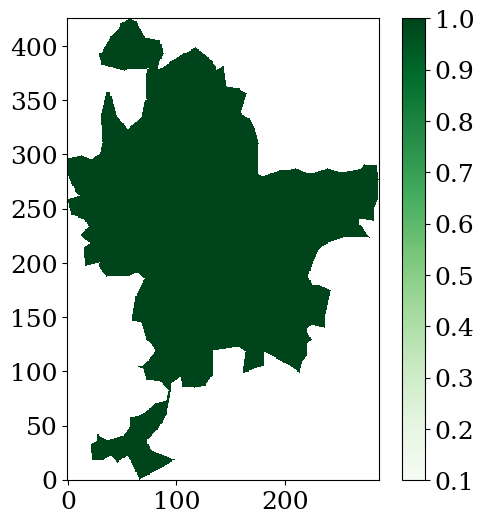

In [7]:
df_masks = pd.read_pickle(f'{DATA_DIR}/df_masks.pkl')
city_data = df_masks[df_masks['name']==CITY_NAME].iloc[0]

city_shape = city_data['shape']
city_mask = city_data['mask']
city_n_rows = city_mask.shape[0]
city_n_cols = city_mask.shape[1]
city_left_x = city_data['left_x']
city_bottom_y = city_data['bottom_y']

city_centroid = city_shape.centroid

my_cmap_mask = cm.get_cmap('Greens').copy()
my_cmap_mask.set_under('w', 0)
norm_mask = colrs.Normalize(vmin=0.1, vmax=1)

plt.figure(figsize=(6, 6))
plt.imshow(city_mask, origin='lower', cmap=my_cmap_mask, norm=norm_mask, interpolation='nearest')
plt.colorbar()
plt.show()

### Load traffic maps

In [8]:
filename = f'hdfs://santiago:9000/land_use/{CITY_NAME}/traffic_maps_median_week.parquet'
sdf_traffic = spark.read.parquet(filename)
sdf_traffic.show(2)

+----+-------------------+--------+-----------+--------------------+
|city|                app|    time|day_of_week|         traffic_map|
+----+-------------------+--------+-----------+--------------------+
|Lyon|Amazon Web Services|02:30:00|  Wednesday|[[0.0, 0.0, 0.0, ...|
|Lyon|Amazon Web Services|08:00:00|  Wednesday|[[0.0, 0.0, 0.0, ...|
+----+-------------------+--------+-----------+--------------------+
only showing top 2 rows



In [9]:
### ⚠️⚠️ Small test, comment this for large dataset ⚠️⚠️
some_rows = sdf_traffic.take(15)
data = []
for row in some_rows:
    data.append(row.asDict())

df = pd.DataFrame(data)
df.iteritems = df.items # workaround for pandas remove of iteritems
sdf_traffic = spark.createDataFrame(df)
sdf_traffic.show(2)
### ⚠️⚠️ Small test, comment this for large dataset ⚠️⚠️

2023-08-14 19:06:10,559 WARN scheduler.TaskSetManager: Stage 3 contains a task of very large size (7542 KiB). The maximum recommended task size is 1000 KiB.


+----+-------------------+--------+-----------+--------------------+
|city|                app|    time|day_of_week|         traffic_map|
+----+-------------------+--------+-----------+--------------------+
|Lyon|Amazon Web Services|02:30:00|  Wednesday|[[0.0, 0.0, 0.0, ...|
|Lyon|Amazon Web Services|08:00:00|  Wednesday|[[0.0, 0.0, 0.0, ...|
+----+-------------------+--------+-----------+--------------------+
only showing top 2 rows



### From Squares to IRIS

In [10]:
# return_schema = spark_types.ArrayType(spark_types.FloatType())
# input_schema = spark_types.ArrayType(spark_types.ArrayType(spark_types.FloatType()))

# @udf(returnType=return_schema)
# def get_traffic_map_iris_old(square_traffic_map: input_schema) -> return_schema:
#     # initialize the iris traffic map
#     iris_traffic_map = np.zeros((number_of_iris))

#     traffic_map = np.array(square_traffic_map)
#     city_n_rows = traffic_map.shape[0]
#     city_n_cols = traffic_map.shape[1]
#     for row_idx in range(city_n_rows):
#         for col_idx in range(city_n_cols):
#             if city_mask[row_idx, col_idx] == 0:
#                 continue

#             traffic_val = traffic_map[row_idx, col_idx]
#             cell_id = int(row_idx*city_n_cols + col_idx)

#             df_iris_ratio_filtered = df_iris_ratio[df_iris_ratio['cell_id'] == cell_id]
            
#             for row in df_iris_ratio_filtered.to_dict('records'):
#                 iris_index = row['iris_index']
#                 ratio = row['ratio']
#                 iris_traffic_map[iris_index] += ratio * traffic_val

#     return iris_traffic_map.tolist()

In [11]:
return_schema = spark_types.ArrayType(spark_types.FloatType())
input_schema = spark_types.ArrayType(spark_types.ArrayType(spark_types.FloatType()))

@udf(returnType=return_schema)
def get_traffic_map_iris(square_traffic_map: input_schema) -> return_schema:

    traffic_map = np.array(square_traffic_map)
    traffic_map = traffic_map.flatten()

    # initialize the iris traffic map
    iris_traffic_map = np.zeros((number_of_iris))

    iris_indexs = set(df_iris_ratio['iris_index'])
    for iris_index in iris_indexs:
        df_iris_ratio_filtered = df_iris_ratio[df_iris_ratio['iris_index'] == iris_index]
        cell_ids = list(df_iris_ratio_filtered['cell_id'])
        ratios = np.array(list(df_iris_ratio_filtered['ratio']))

        traffic_cell_ids = traffic_map[cell_ids]
        traffic_cell_ids = traffic_cell_ids * ratios
        iris_traffic = np.sum(traffic_cell_ids)
        iris_traffic_map[iris_index] = iris_traffic

    return iris_traffic_map.tolist()

In [12]:
sdf_traffic = sdf_traffic.withColumn('traffic_map_iris', get_traffic_map_iris(sdf_traffic['traffic_map']))
# sdf_traffic.show(2)

## Save data

In [13]:
sdf_traffic.write.parquet(f'hdfs://santiago:9000/land_use/{CITY_NAME}/iris_traffic_maps_median_week.parquet', mode='overwrite')

2023-08-14 19:06:11,829 WARN scheduler.TaskSetManager: Stage 4 contains a task of very large size (7542 KiB). The maximum recommended task size is 1000 KiB.
